In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from model.forest import train_forest

from model.gradient_boosting import train_gradient_boosting
from utils import show_cluster, plot_clustermap, plot_legend, get_importances

In [3]:
data = pd.read_csv("../data/genes_transformed.csv", delimiter=",", decimal='.')

Acc: 0.9030329153605016, F1 Score: 0.9233187681390641


/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


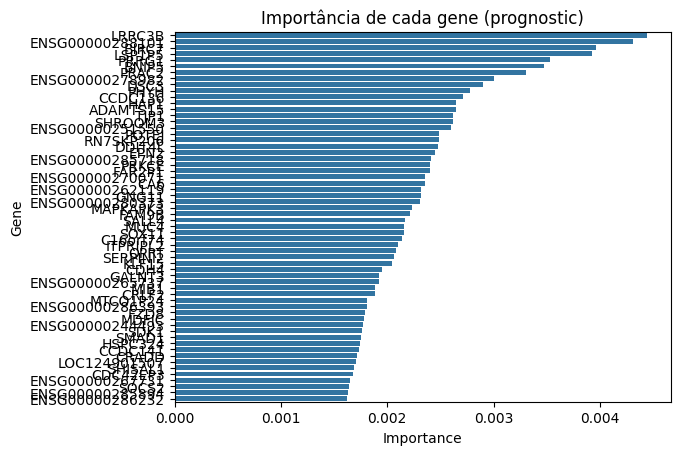

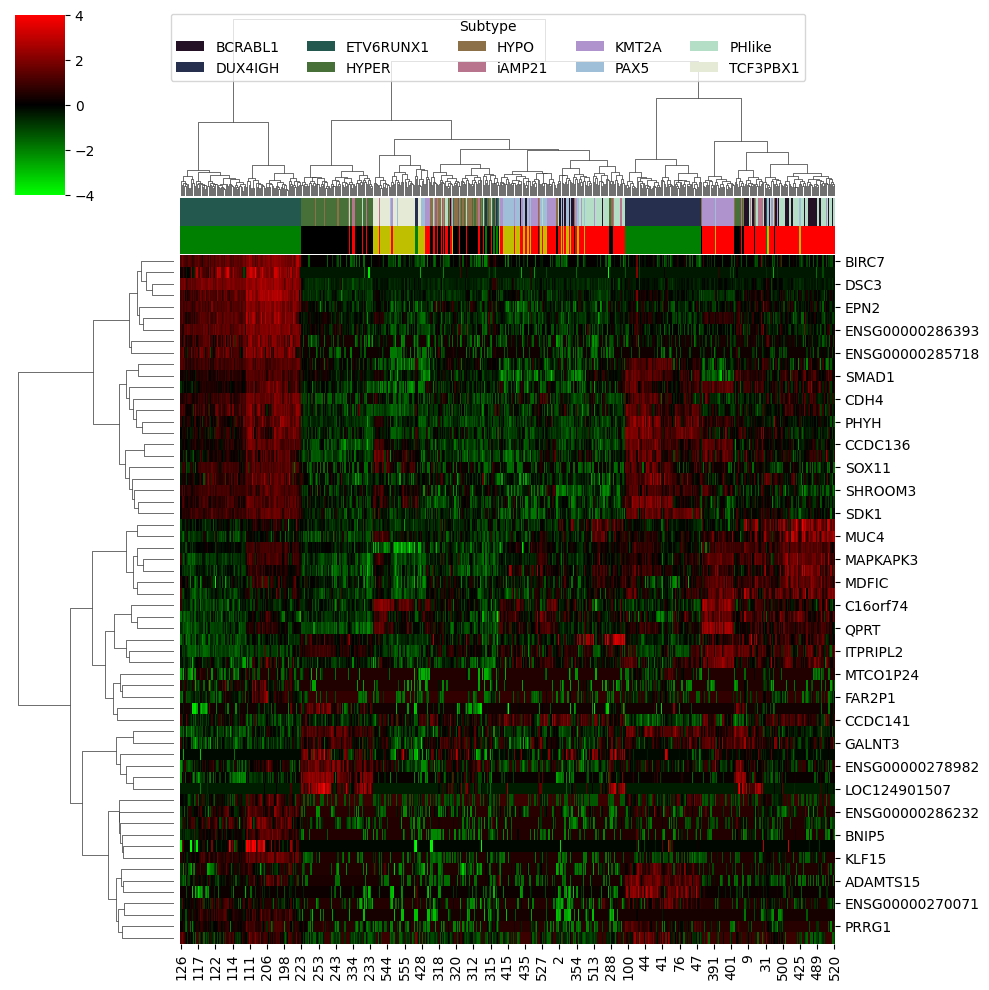

In [5]:
show_cluster(data, "prognostic", top=60)

/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

Acc: 0.7921690590111643, F1 Score: 0.8512441058450031


/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


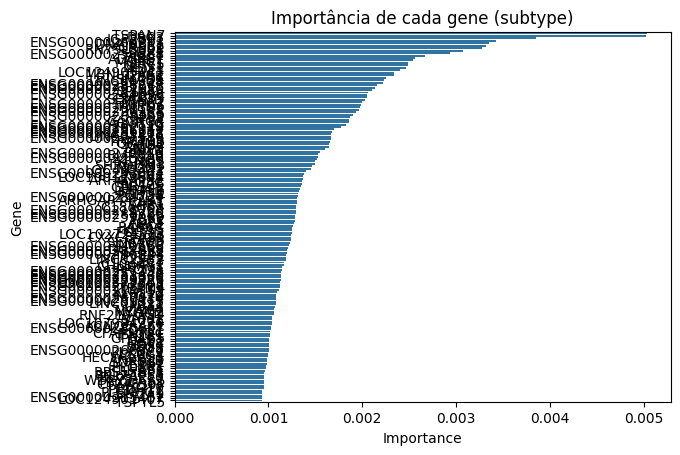

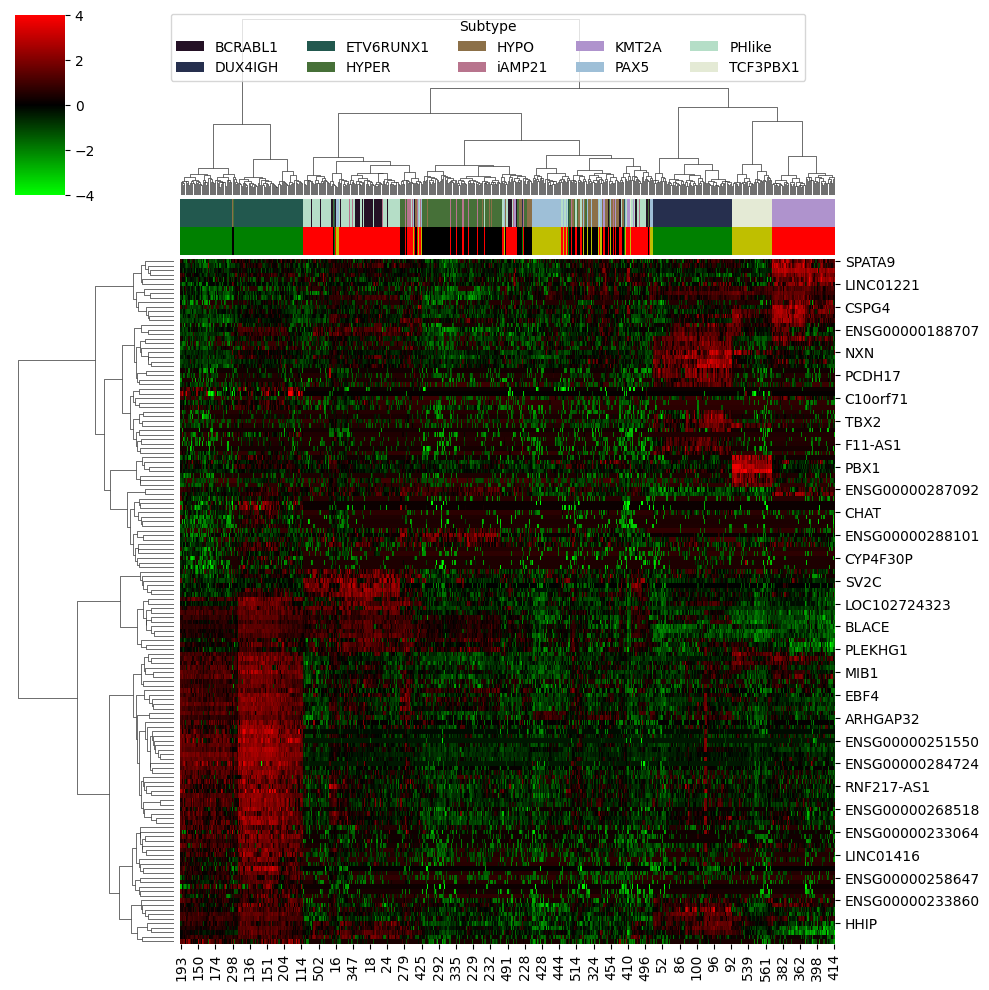

In [6]:
show_cluster(data, "subtype", top=150)

In [147]:
importances_by_subtype = {}
forest_params = {
  "n_estimators": 64,
  "max_depth": 2,
  "class_weight": "balanced"
}
f1s_by_subtype = {}
tops = list(range(5, 60, 5))

genes = set()
for subtype in data["subtype"].unique():
  targeted_data = data.copy()
  targeted_data["subtype_target"] = targeted_data["subtype"] == subtype

  response = train_forest("subtype_target", data=targeted_data, **forest_params)
  print(f"\n======== Subtype {subtype} - F1 Score {response.f1} - ACC {response.acc} - Recall {response.recall} ========")

  f1s_by_subtype[subtype] = []
  targets = []
  for top in tops:
    importances_target = get_importances(response.model.feature_importances_, response.feature_names, top=top)
    current_important_data = targeted_data.copy()[["subtype_target", *importances_target.index]]

    search_params = None
    if subtype in ["iAMP21", "BCRABL1"]:
      search_params = {"n_estimators": (2, 4, 8, 16, 32, 64), "max_depth": (2, 4, 16, 64)}

    subset_response = train_forest("subtype_target", data=current_important_data, grid_search_scoring="recall", grid_search_params=search_params, **forest_params)
    f1s_by_subtype[subtype].append(subset_response.f1)
    targets.append(importances_target)

  print(f"F1s for {subtype}: {str(f1s_by_subtype[subtype])}")
  # enumerated_f1s = list(enumerate(f1s_by_subtype[subtype]))
  # i, score = next((x for x in enumerated_f1s if x[1] >= 0.8)) or enumerated_f1s[-1]
  i, max_f1 = max(enumerate(f1s_by_subtype[subtype]), key=lambda x: x[1])
  # i, score = next((x for x in enumerated_f1s if max_score - x[1] <= 0.01))
  print(f"Chosen top: {tops[i]}, {i=} {max_f1=}")

  importances_target = targets[i]
  importances_by_subtype[subtype] = importances_target
  genes |= set(importances_target.index)

  cluster_data = targeted_data.drop(axis=1, labels=["prognostic", "subtype", "subtype_target"])[importances_target.index].transpose()
  col_colors = [targeted_data["subtype_target"].map({ True: "yellow", False: "black" })]

  # g = plot_clustermap(cluster_data, col_colors)
  # g.figure.suptitle(subtype, y=1)
  # plt.show()

  # print(importances_target.to_string())

important_genes = list(genes)


======== Subtype BCRABL1 - F1 Score 0.5 - ACC 0.6924812030075188 - Recall 0.4 ========
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 32, 'n_jobs': -1, 'oob_score': False, 'random_state': 774, 'verbose': 0, 'warm_start': False}
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 16, 'n_jobs': -1, 'oob_score': False, 'random_state': 774, 'verbose': 0, 'warm_start': False}
Best params: {'bootstrap': True, 'ccp_alpha': 0.0, 'clas

<Axes: title={'center': 'Importância de cada gene por subtipo One-vs-All'}, xlabel='Importance', ylabel='Gene'>

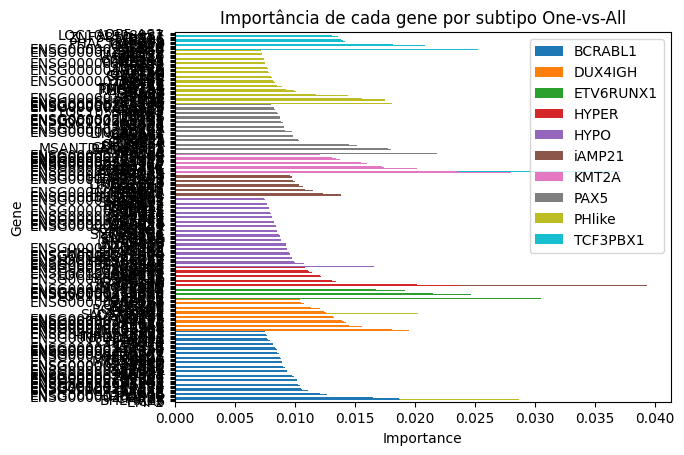

In [149]:
one_vs_all_df = pd.concat(importances_by_subtype.values(), axis=1).fillna(0)
one_vs_all_df.columns = importances_by_subtype.keys()
one_vs_all_df.plot(kind="barh", stacked=True, xlabel='Importance', ylabel='Gene', title="Importância de cada gene por subtipo One-vs-All")

/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


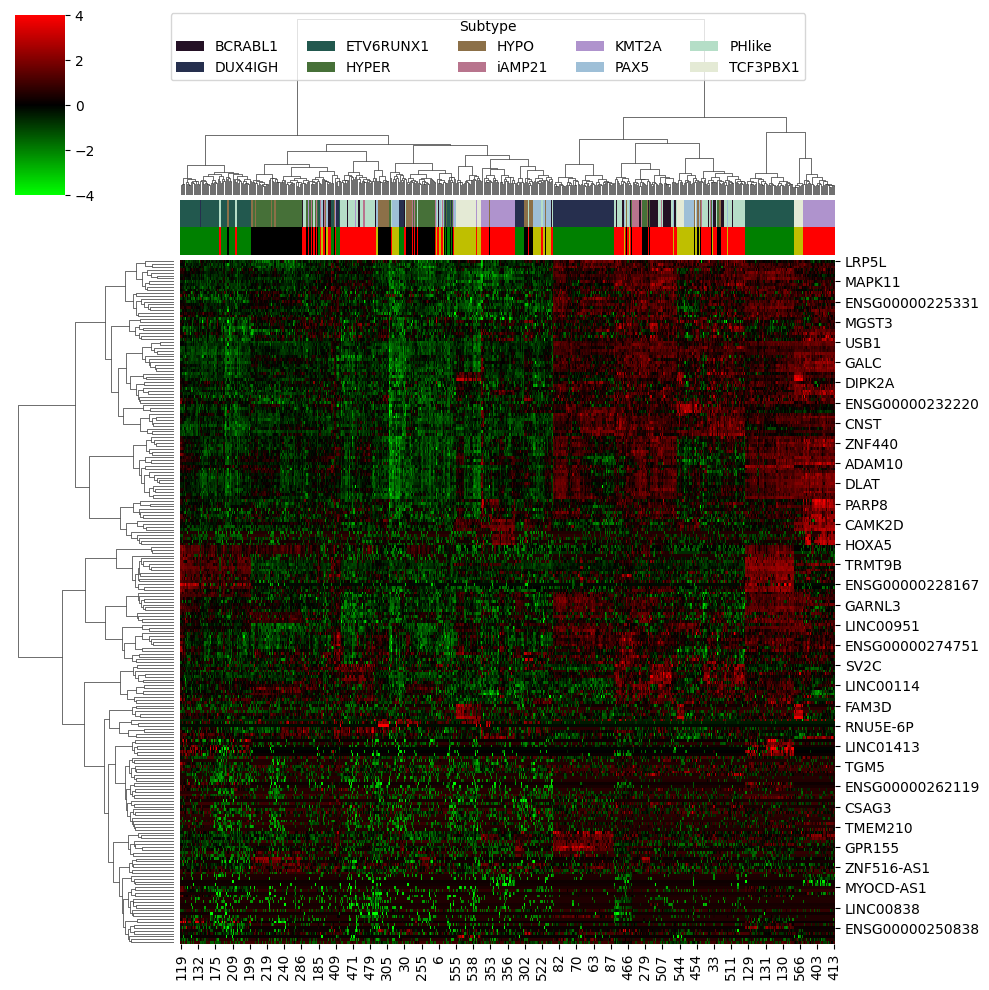

In [24]:
cluster_data = data.drop(axis=1, labels=["prognostic", "subtype"])[important_genes].transpose()

subtypes = data["subtype"]
palette = sns.cubehelix_palette(subtypes.unique().size, light=.9, dark=.1, reverse=True, start=1, rot=-2)
lut = dict(zip(map(str, subtypes.unique()), palette))
col_colors = [subtypes.map(lut), data["prognostic"].map({ "POOR": "r", "GOOD": "g", "MODERATE": "y", "UNKNOWN": "black" })]

g = plot_clustermap(cluster_data, col_colors)
plot_legend(g, subtypes, lut)

plt.show()

In [142]:
# one_vs_all_search_params = {"n_estimators": (128, 256, 512), "max_depth": (64, 128, 256, None), "class_weight": ("balanced", None), "max_features": (None, "sqrt", "log2")}
# one_vs_all_response = train_forest(target="subtype", data=data[["prognostic", "subtype", *important_genes]], grid_search_params=one_vs_all_search_params)
one_vs_all_response = train_forest(target="subtype", data=data[["prognostic", "subtype", *important_genes]], n_estimators=512, class_weight=None, max_depth=64, max_features=None)
print(one_vs_all_response.model.get_params())
print(f"F1 Score: {one_vs_all_response.f1}, Acc: {one_vs_all_response.acc}")

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 64, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 512, 'n_jobs': -1, 'oob_score': False, 'random_state': 774, 'verbose': 0, 'warm_start': False}
F1 Score: 0.8924824771836742, Acc: 0.8476342371079213


In [163]:
# one_vs_all_search_params = {"learning_rate": (0.05, 0.1, 1), "max_features": (0.05, 0.1, 0.15, 0.2, 0.5,), "min_samples_leaf": (5, 10, 15, 20), "l2_regularization": (0, 0.5, 1)}
# one_vs_all_response = train_gradient_boosting(target="subtype", data=data[["prognostic", "subtype", *important_genes]], grid_search_params=one_vs_all_search_params, max_depth=32)
one_vs_all_response = train_gradient_boosting(target="subtype", data=data[["prognostic", "subtype", *important_genes]], learning_rate=0.1, max_features=0.15, min_samples_leaf=15, max_depth=32)
print(one_vs_all_response.model.get_params())
print(f"F1 Score: {one_vs_all_response.f1}, Acc: {one_vs_all_response.acc}")
print(one_vs_all_response.test_report)

{'categorical_features': 'warn', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': 32, 'max_features': 0.15, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 15, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': 774, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
F1 Score: 0.8954266910989869, Acc: 0.8533111954459203
              precision    recall  f1-score   support

     BCRABL1       0.71      0.75      0.73        16
     DUX4IGH       1.00      1.00      1.00        28
   ETV6RUNX1       0.93      1.00      0.97        43
       HYPER       0.85      0.94      0.89        31
        HYPO       1.00      0.60      0.75        15
       KMT2A       0.96      1.00      0.98        25
        PAX5       0.84      0.94      0.89        17
      PHlike       0.81      0.81      0.81        31
  

/Users/igormandello/projects/lla-analysis/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


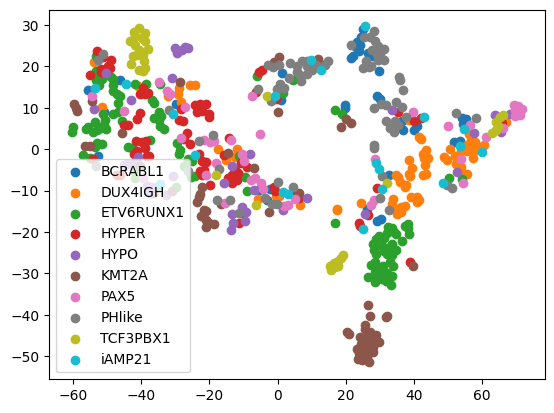

In [26]:
tsne = TSNE(n_components=2, random_state=42, perplexity=18, n_jobs=16, early_exaggeration=20, n_iter=5000).fit_transform(data.drop(axis=1, labels=["prognostic", "subtype"])[important_genes])
fig, ax = plt.subplots()

groups = pd.DataFrame(tsne, columns=["x", "y"]).assign(category=data["subtype"]).groupby("category")
for name, points in groups:
    ax.scatter(points.x, points.y, label=name)

ax.legend()

In [ ]:
for x in [5, 10, 12, 15, 18, 20, 25, 30, 35, 40, 50]:
  for y in [6, 12, 20, 25, 50, 75]:
    print(f"{x} {y}")
    tsne = TSNE(n_components=2, random_state=42, perplexity=x, n_jobs=16, early_exaggeration=y, max_iter=5000).fit_transform(data.drop(axis=1, labels=["prognostic", "subtype"])[important_genes])
    fig, ax = plt.subplots()

    groups = pd.DataFrame(tsne, columns=["x", "y"]).assign(category=data["subtype"]).groupby("category")
    for name, points in groups:
        ax.scatter(points.x, points.y, label=name)

    ax.legend()
    plt.show()